In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import os

import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import yass
from yass import preprocess
from yass import process

from neural_noise.explorer import (SpikeTrainExplorer,
                                   RecordingExplorer)


import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
logging.basicConfig(level=logging.ERROR)

Running pipeline with triage NN

In [8]:
yass.set_config('../ej49_config.yaml')

cfg = yass.read_config()

In [4]:
score, clear_index, spike_times = preprocess.run()

INFO:yass.batch.batch:Number of batches: 1. Batch size: 6000000 (observations  per channel. Residual: 0. Total number of observations 6000000
INFO:yass.preprocess.run:Initialized butterworth batch processor: BatchProcessor for file /ssd/data/eduardo/ej49_data1_set1.bin (588000000 bytes). Already processed 0 out of 1 batches. Max memory: 1000000000 bytes
INFO:yass.batch.batch:Number of batches: 3. Batch size: 2551020 (observations  per channel. Residual: 897960. Total number of observations 6000000
INFO:yass.batch.batch:Number of batches: 3. Batch size: 2551020 (observations  per channel. Residual: 897960. Total number of observations 6000000
INFO:yass.preprocess.run:Initialized standarization batch processor: BatchProcessor for file /ssd/data/eduardo/tmp/filtered.bin (2352000000 bytes). Already processed 0 out of 3 batches. Max memory: 1000000000 bytes
INFO:yass.batch.batch:Number of batches: 3. Batch size: 2551020 (observations  per channel. Residual: 0. Total number of observations 7

In [18]:
spike_times[0][:10]

array([[1074,    0],
       [1121,    0],
       [1168,    0],
       [1333,    0],
       [1396,    0],
       [1430,    0],
       [1668,    0],
       [1704,    0],
       [2107,    0],
       [2492,    0]], dtype=int32)

In [7]:
spike_train, spike_left, templates = process.run(score,
                                                 clear_index,
                                                 spike_times)

INFO:yass.process.run:Triaging...
INFO:yass.process.run:Coresettting...
INFO:yass.process.run:Masking...
INFO:yass.process.run:Clustering...
100% (8 of 8) |###########################| Elapsed Time: 0:00:13 Time: 0:00:13
INFO:yass.process.run:Getting Templates...
100% (1 of 1) |###########################| Elapsed Time: 0:00:01 Time: 0:00:01
INFO:yass.process.run:Mainprocess done in 29 seconds.
INFO:yass.process.run:	triage:	0.445182 seconds
INFO:yass.process.run:	coreset:	3.781132 seconds
INFO:yass.process.run:	masking:	0.254348 seconds
INFO:yass.process.run:	clustering:	19.307001 seconds
INFO:yass.process.run:	make templates:	5.200328 seconds


In [11]:
path_to_recordings = os.path.join(cfg.root, 'tmp/standarized.bin')
path_to_geometry = os.path.join(cfg.root, cfg.geomFile)

In [21]:
explorer_rec = RecordingExplorer(path_to_recordings,
                                 path_to_geometry,
                                 dtype='float64',
                                 window_size=cfg.spikeSize,
                                 n_channels=cfg.nChan,
                                 neighbor_radius=cfg.spatialRadius)

In [48]:
explorer_train = SpikeTrainExplorer(templates,
                                    spike_train,
                                    explorer_rec)

In [22]:
explorer_rec.data.shape

(7653060, 49)

In [33]:
templates.shape

(49, 31, 88)

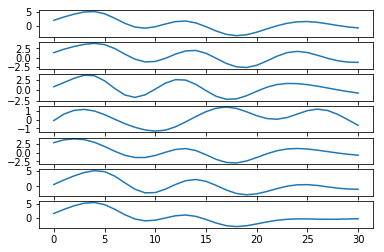

In [23]:
explorer_rec.plot_waveform_around_channel(time=1000, channel=0)

In [46]:
%reload_ext autoreload

In [51]:
explorer_train.plot_templates([0, 1, 2])

TypeError: isinstance expected 2 arguments, got 1

In [11]:
nnd = NeuralNetDetector(cfg)
proj = nnd.load_w_ae()

In [12]:
proj.shape

(31, 3)

In [13]:
def templates_in_feature_space(templates,proj):
    """Templates dimensionality reduction
    """
    R, nfeat = proj.shape
    nchannel, R, n_templates = templates.shape
    
    return np.transpose(np.reshape(
        np.matmul(np.reshape(np.transpose(templates,[0,2,1]),(-1,R)),proj),
        (nchannel, n_templates, nfeat)),(0,2,1))

In [15]:
spt_clean = spikeTrain_clear[:,0]
id_clean = spikeTrain_clear[:,1]
templates = mp.templates
cluster_id = 2
n_cluster_plot = 5
neighbor = cfg.neighChannels
plot_length = 15
plot_width = 10
cols = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plot_name1 = 'waveform.pdf'
plot_name2 = 'scatter_score.pdf'
plot_wf = True
plot_score = 1

In [16]:
# get parameters
R, nfeat = proj.shape
spike_size = int((R-1)/2)
nchannel, R, n_templates = templates.shape

# dimension reduction of templates
templates_in_feature = templates_in_feature_space(templates,proj)

# find similar templates to template in cluster_id, this will give us overlapping
# clusters
k_idx = close_templates(templates_in_feature, cluster_id, n_cluster_plot)

In [17]:
def find_reduced_template(cluster_id):
    """
    Load template with a given cluster_id but only load neighboring channels
    """
    # find the template for cluster_id
    t_interest = templates[:,:,cluster_id]

    # find the main channel for that template
    c_main = np.argmax(np.max(t_interest,axis=1))

    # find neighbors for that channel
    ch_idx = np.where(neighbor[c_main])[0]
        
    return templates[ch_idx, :, cluster_id]

In [18]:
def find_reduced_similar_templates(cluster_id, k_similar):
    template_ids = close_templates(templates_in_feature, cluster_id, k_similar)
    reduced_templates = np.vstack([find_reduced_template(cid) for cid in template_ids])
    return reduced_templates, np.array(template_ids)

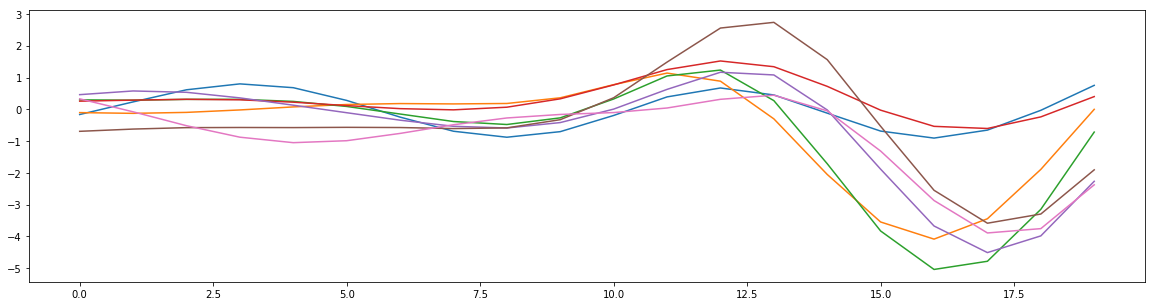

In [19]:
# get_waveforms_and_scores_for_template is breaking because of a spike at time 5999986
plt.rcParams['figure.figsize'] = (20, 5)
plt.plot(rec[5999986-10:5999986+10, [ 1  ,5 , 9 ,12 ,17, 20 ,24]])

In [20]:
nchannel, R, n_templates = templates.shape

def get_waveforms_and_scores_for_template(template_id, flatten=True):
    """
    Return the waveform for a given template
    
    Parameters
    ----------
    flatten: bool
        flatten waveforms along channels
    """
    # get times for spikes whose id correspond the template_id
    spt_k = spt_clean[id_clean == template_id]
        
    # get the number of waveforms used to build that template
    nn = spt_k.shape[0]
    
    # find main channel and neighboring channels
    t_interest = templates[:,:,cluster_id]
    c_main = np.argmax(np.max(t_interest,axis=1))
    ch_idx = np.where(neighbor[c_main])[0]
    
    # get the waveforms
    wf = np.zeros((nn, R, ch_idx.shape[0]))

    for j in range(nn):
        try:
            wf[j] = rec[(spt_k[j]-spike_size):(spt_k[j]+spike_size+1),ch_idx]
        except Exception as e:
#             print(spt_k[j])
            pass

    # also get the scores
    score = np.transpose(np.reshape(np.matmul(
        np.reshape(np.transpose(wf,(0,2,1)),(-1, R)),proj),(nn,ch_idx.shape[0],nfeat)),(0,2,1))
    
    if flatten:
        wf = np.reshape(wf, [wf.shape[0], -1])
        score = np.reshape(score, [score.shape[0], -1])
    
    return wf, score

In [21]:
def get_waveforms_and_scores_for_templates(templates):
    """
    Return waveforms and scores for a group of templates
    along with a vector that indicates the cluster_id for each
    one
    """
    res = [get_waveforms_and_scores_for_template(template_id) for template_id in templates]
    wfs = np.vstack([t[0] for t in res])
    scores = np.vstack([t[1] for t in res])
    labels = np.hstack([np.ones(len(l[0]))*t for l, t in zip(res, templates)])
    return wfs, scores, labels

In [22]:
wfs, score, labels = get_waveforms_and_scores_for_templates(np.unique(id_clean))

In [23]:
wfs.shape, score.shape, labels.shape

((102193, 155), (102193, 15), (102193,))

In [24]:
# np.save('wfs', wfs)
# np.save('score', score)
# np.save('labels', labels)

In [25]:
def pca_plot(data, colors):
    """
    Reduce dimensionality using PCA
    and plot data
    """
    pca = PCA(n_components=2)

    pca.fit(data)
    reduced = pca.transform(data)
    
    for color in np.unique(colors).astype('int'):
        plt.scatter(reduced[colors == color, 0], reduced[colors == color, 1], label=color, alpha=0.7)

    plt.legend()
    plt.show()
    

In [26]:
def lda_plot(data, colors, ax=None):
    """
    Reduce dimensionality using LDA
    and plot data
    """
    ax = plt if ax is None else ax

    lda = LDA(n_components=2)
    lda.fit(data, colors)
    reduced = lda.transform(data)

    for color in np.unique(colors).astype('int'):
        ax.scatter(reduced[colors == color, 0], reduced[colors == color, 1],
                    label='Cluster {}'.format(color), alpha=0.7)

    ax.legend()

In [27]:
def visualize_cluster(cluster_id, k_similar, ax=None):
    """
    Project in 2D a cluster id along with k_similar
    clusters
    """
    template_ids = close_templates(templates_in_feature, cluster_id, k_similar+1)
    wf, scores, labels = get_waveforms_and_scores_for_templates(template_ids)
    lda_plot(scores, labels, ax=ax)

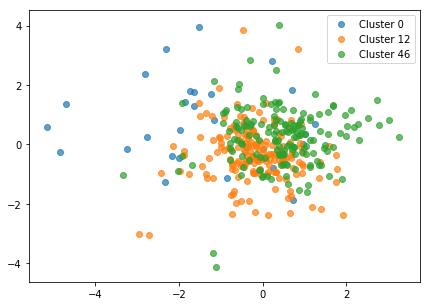

In [28]:
plt.rcParams['figure.figsize'] = (7,5)
visualize_cluster(0, 2)

In [29]:
cluster_ids = np.unique(id_clean)

In [30]:
len(cluster_ids)

116

/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


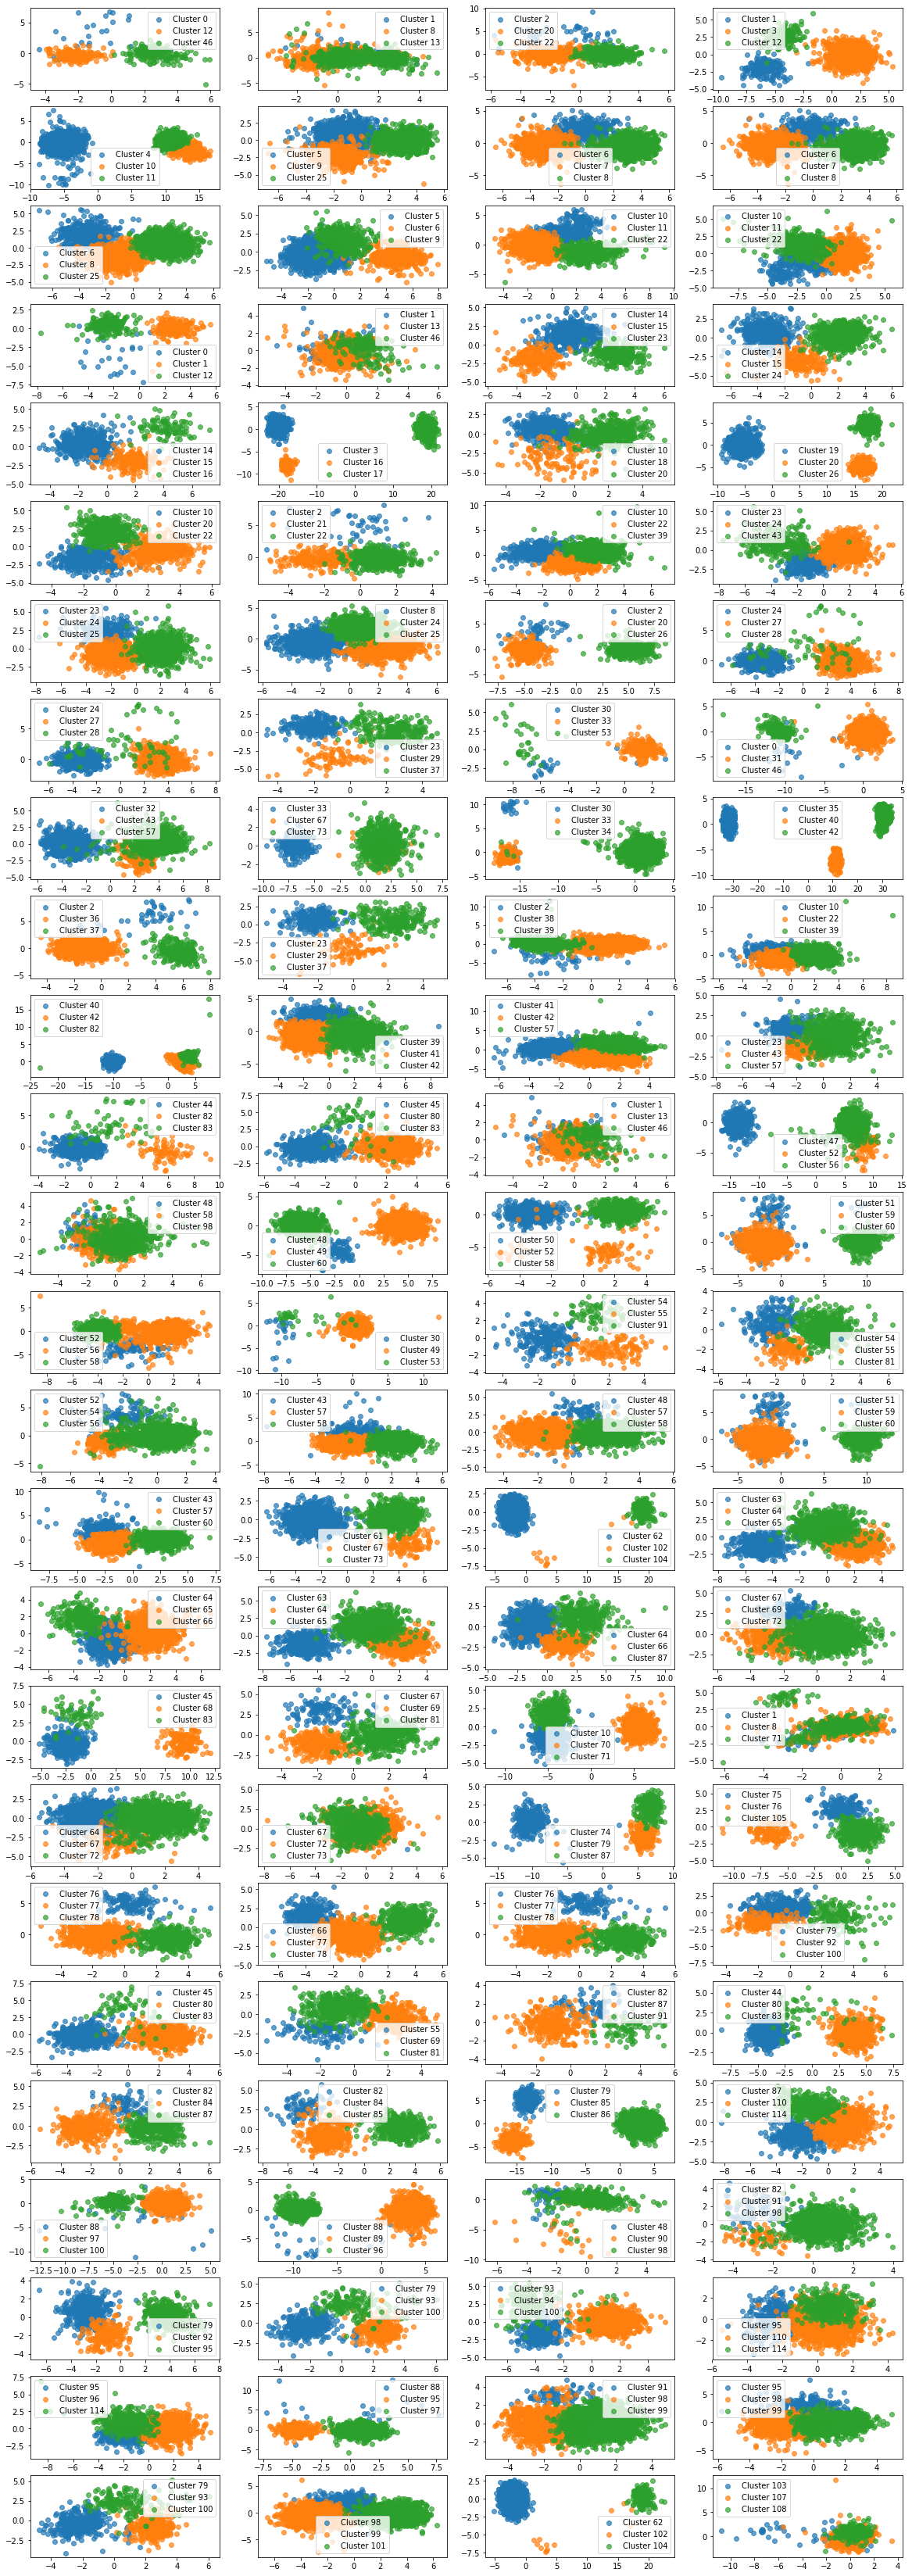

In [31]:
plt.rcParams['figure.figsize'] = (20, 60)
f, axs = plt.subplots(26, 4)
axs = [item for sublist in axs for item in sublist]

for ax, cluster_id in zip(axs, cluster_ids):
    visualize_cluster(cluster_id, k_similar=2, ax=ax)

plt.savefig('lda.png')

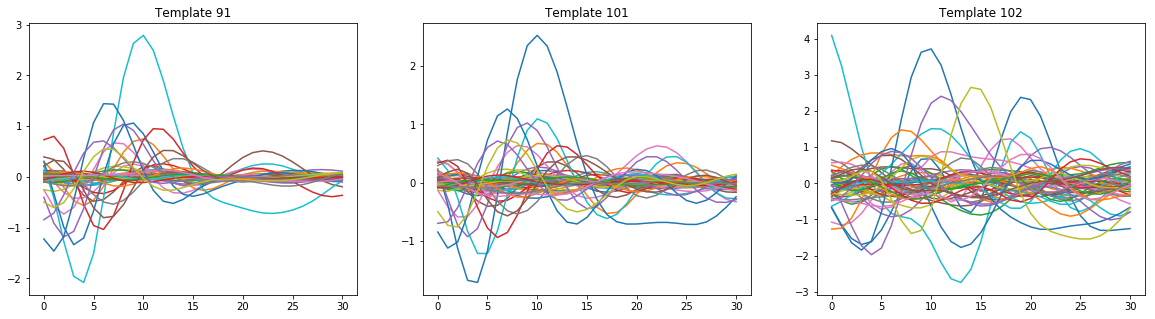

In [344]:
plt.rcParams['figure.figsize'] = (20, 5)
f, axs = plt.subplots(1, 3)

for cluster_id, ax in zip((91, 101, 102), axs):
    ax.plot(mp.templates[:, :, cluster_id].T)
    ax.set_title('Template {}'.format(cluster_id))

plt.legend()
plt.savefig('wf1.pdf')
plt.show()

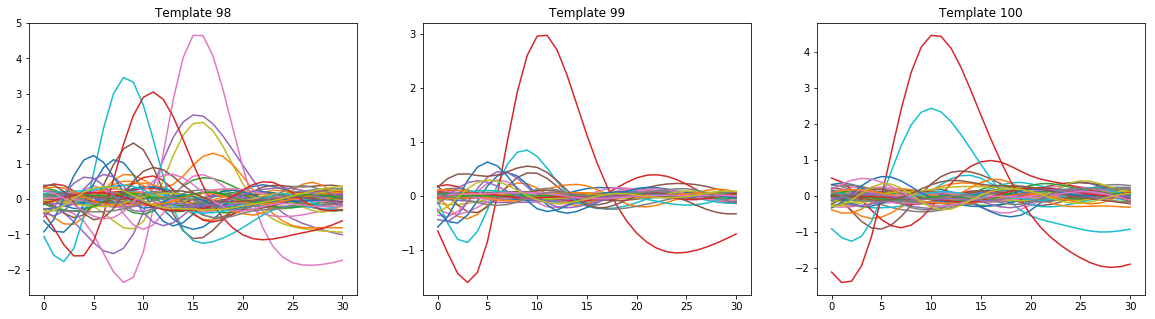

In [345]:
plt.rcParams['figure.figsize'] = (20, 5)
f, axs = plt.subplots(1, 3)

for cluster_id, ax in zip((98, 99, 100), axs):
    ax.plot(mp.templates[:, :, cluster_id].T)
    ax.set_title('Template {}'.format(cluster_id))

plt.legend()
plt.savefig('wf2.pdf')
plt.show()

In [ ]:
def plot_cluster(rec, proj, spt_clean, id_clean, templates, cluster_id, 
                 n_cluster_plot, neighbor, plot_length, plot_width, cols, plot_name1, plot_name2, plot_wf, plot_score):
    
    # get parameters
    R, nfeat = proj.shape§
    spike_size = int((R-1)/2)
    nchannel, R, n_templates = templates.shape

    print('templates raw', templates.shape)
    
    # dimension reduction of templates
    templates_in_feature = templates_in_feature_space(templates,proj)
    
    print('templates in ft', templates_in_feature.shape)
        
        
    # choose neighboring templates
    k_idx = close_templates(templates_in_feature, cluster_id, n_cluster_plot)
    
    print('cluster id', cluster_id, 'similar clusters', k_idx)

    # find main channel and neighboring channels
    t_interest = templates[:,:,cluster_id]
    
    print('t interest', t_interest.shape)

    c_main = np.argmax(np.max(t_interest,axis=1))
    ch_idx = np.where(neighbor[c_main])[0]
    
    # get waveforms for all
    wf_all = list()
    score_all = list()
    for k in k_idx:
        # find clear spike times whose cluster_id is the template we are looking for
        # this are the ones that were used to build the template
        spt_k = spt_clean[id_clean == k]
        
        # get the number of waveforms used to build that template
        nn = spt_k.shape[0]
        print('nn', nn)
        
        # look for those waveforms
        wf = np.zeros((nn, R, ch_idx.shape[0]))
        for j in range(nn):
            wf[j] = rec[(spt_k[j]-spike_size):(spt_k[j]+spike_size+1),ch_idx]

        score = np.transpose(np.reshape(np.matmul(
            np.reshape(np.transpose(wf,(0,2,1)),(-1, R)),proj),(nn,ch_idx.shape[0],nfeat)),(0,2,1))

        wf_all.append(wf)
        score_all.append(score)
    
    max_val = np.max(templates[ch_idx][:,:,k_idx])*3
    min_val = np.min(templates[ch_idx][:,:,k_idx])*3

    # plot waveforms
    if plot_wf:
        count = 1
        time_val = np.arange(R)/20.
        fig = plt.gcf()
        fig.set_size_inches(plot_length, plot_width)
        fig.suptitle("Cluster of interest: " + str(cluster_id)+", main channel: "+str(c_main), fontsize=16)
        for c in range(ch_idx.shape[0]):
            for k in range(k_idx.shape[0]):
                plt.subplot(ch_idx.shape[0],k_idx.shape[0],count)
                plt.plot(time_val,wf_all[k][:,:,c].T)
                plt.plot(time_val,np.mean(wf_all[k][:,:,c], axis=0), linewidth = 5, color='red')
                plt.ylim((min_val,max_val))
                if k == 0:
                    plt.ylabel('channel '+str(ch_idx[c]))
                if c == ch_idx.shape[0]-1:
                    plt.xlabel('time (ms)')
                if c == 0:
                    plt.title('cluster '+str(k_idx[k]))
                count += 1
        plt.savefig(plot_name1)
        plt.show()
    
    
    if plot_score:
        print('templates...', ch_idx)
        print(templates_in_feature[ch_idx][:,:,k_idx].shape)
        tt = np.transpose(templates_in_feature[ch_idx][:,:,k_idx],(2,1,0))
        print(tt.shape)
        tt = np.reshape(tt,[tt.shape[0],-1])
        print(tt.shape)

        pca = PCA(n_components=2)
        pca.fit(tt)
        
#         lda = LDA(n_components=2)
#         lda.fit(tt, range(tt.shape[0]))

        fig = plt.gcf()
        fig.set_size_inches(10, 10)
        for k in range(k_idx.shape[0]):
            print('scores for', k, k_idx[k])
            score_temp = np.reshape(score_all[k],(score_all[k].shape[0],-1))
            print(score_temp.shape)
            score_temp = pca.transform(score_temp)
#             score_temp = lda.transform(score_temp)
            print(score_temp.shape)
            plt.scatter(score_temp[:,0],score_temp[:,1],color=cols[k])

        legend_name = [None]*k_idx.shape[0]
        for k in range(k_idx.shape[0]):
            legend_name[k] = "Cluster "+str(k_idx[k])

        plt.legend(legend_name)
        plt.xlabel('Dimension 0')
        plt.ylabel('Dimension 1')
        plt.savefig(plot_name2)
        plt.show()
        
    
    

In [ ]:
plot_cluster(rec, proj, spt_clean, id_clean, templates, cluster_id, 
             n_cluster_plot, neighbor, plot_length, plot_width, cols, plot_name1, plot_name2, plot_wf, plot_score)